## Installs

In [0]:
!sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [1,253 kB]
Get:15 http://ar

In [0]:
!pip install stable-baselines[mpi]

In [0]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines[mpi]==2.10.0

TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [0]:
import stable_baselines
stable_baselines.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'2.10.0'

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip 

--2020-06-16 02:07:29--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.95.144.123, 54.88.63.64, 3.224.101.150, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.95.144.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  5.96MB/s    in 2.2s    

2020-06-16 02:07:32 (5.96 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Imports

In [0]:
import time
from collections import Counter

import gym
import numpy as np

In [0]:
from stable_baselines.common.policies import MlpPolicy

In [0]:
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines import DQN

In [0]:
from stable_baselines.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines import results_plotter

### Prepare video recording

In [0]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [0]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [0]:
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

In [0]:
def actions_taken(model, num_episodes=10):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    all_episode_actions = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            all_episode_actions.append(action)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return all_episode_actions

In [0]:
os.makedirs('./models/', exist_ok=True)

## Train a Dueling DQN agent


In [0]:
from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.bench import Monitor

In [0]:
# Create log dir
log_dir = "./duel_logs/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('SpaceInvaders-ram-v0')
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

In [0]:
checkpoint_callback = CheckpointCallback(save_freq=5000, save_path=log_dir,
                                         name_prefix='duel_dqn')
# Separate evaluation env
eval_env_callback = make_vec_env('SpaceInvaders-ram-v0', n_envs=1, monitor_dir=log_dir)
# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env_callback, best_model_save_path=log_dir,
                             n_eval_episodes=20,
                             log_path=log_dir, eval_freq=10000,
                             deterministic=True, render=False)

In [0]:
learning_rate = 1e-4 #@param ["1e-3", "5e-4", "1e-4", "2e-4"] {type:"raw"}
exploration_final_eps = 0.05 #@param ["0.01", "0.02", "0.05", "0.1"] {type:"raw"}
gamma = 0.99 #@param ["0.999", "0.99", "0.9"] {type:"raw"}
exploration_fraction = 0.5 #@param ["0.1", "0.5", "0.9", "1.0"] {type:"raw"}
buffer_size = 10000 #@param ["10000", "50000", "100000"] {type: "raw"}
total_timesteps = 200000 #@param ["20000", "50000", "100000", "200000", "500000", "1000000"] {type:"raw"}
network = [128, 128] #@param ["[64, 64]", "[128, 128]", "[256, 256]", "[64, 64, 64]"] {type:"raw"}
seed = 42 #@param ["0", "42"] {type:"raw"}


In [0]:
# Activate only the prioritized replay
kwargs = {'double_q': False, 'prioritized_replay': False,
          'policy_kwargs': dict(dueling=True, layers=network)}

duel_dqn = DQN('MlpPolicy', env,
               gamma=gamma,
               learning_rate=learning_rate,
               buffer_size=buffer_size,
               exploration_fraction=exploration_fraction,
               exploration_final_eps=exploration_final_eps,
               verbose=1,
               seed=seed,
               tensorboard_log="./duel_space_invaders_ram_tensorboard/",
               **kwargs)

In [0]:
LOG_DIR = './duel_space_invaders_ram_tensorboard/'

In [0]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://14fc956bdf9a.ngrok.io


In [0]:
# Use a separate environement for evaluation
eval_env = gym.make('SpaceInvaders-ram-v0')

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(duel_dqn, eval_env, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:252.00 +/- 34.40


In [0]:
all_actions = actions_taken(duel_dqn)
actions_counter = Counter(all_actions)
actions_counter

In [0]:
fig, ax = plt.subplots()
bars = ax.bar(actions_counter.keys(),
              actions_counter.values(), color='grey')
ax.set_title('Pre-trained model actions dist')

In [0]:
start = time.time()
duel_dqn.learn(total_timesteps=total_timesteps,
               log_interval=10, tb_log_name='duel_dqn_v8',
               callback=[checkpoint_callback, eval_callback])
print('Time in minutes: ' + str((time.time()-start)/60.0))
duel_dqn.save("./models/duel_dqn_ram_v9")

/usr/local/lib/python3.6/dist-packages/stable_baselines/common/callbacks.py:277: UserWarning: Training and eval env are not of the same type<Monitor<TimeLimit<AtariEnv<SpaceInvaders-ram-v0>>>> != <stable_baselines.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f823181c5c0>
  "{} != {}".format(self.training_env, self.eval_env))


--------------------------------------
| % time spent exploring  | 93       |
| episodes                | 10       |
| mean 100 episode reward | 118      |
| steps                   | 6547     |
--------------------------------------
Eval num_timesteps=10000, episode_reward=79.50 +/- 83.22
Episode length: 726.85 +/- 214.13
New best mean reward!
--------------------------------------
| % time spent exploring  | 87       |
| episodes                | 20       |
| mean 100 episode reward | 131      |
| steps                   | 13658    |
--------------------------------------
Eval num_timesteps=20000, episode_reward=127.00 +/- 109.98
Episode length: 848.05 +/- 227.79
New best mean reward!
--------------------------------------
| % time spent exploring  | 80       |
| episodes                | 30       |
| mean 100 episode reward | 137      |
| steps                   | 20427    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 73 

In [0]:
# Use a separate environement for evaluation
eval_env = gym.make('SpaceInvaders-ram-v0')

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(duel_dqn, eval_env, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:270.00 +/- 0.00


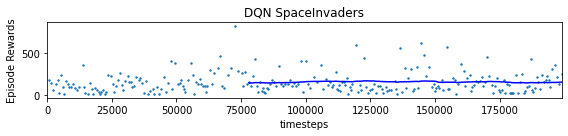

In [0]:
# Helper from the library
results_plotter.plot_results([log_dir], 2e5, results_plotter.X_TIMESTEPS,
                             "DQN SpaceInvaders")

In [0]:
record_video('SpaceInvaders-ram-v0', duel_dqn, video_length=5000,
             prefix='duel_dqn-SpaceInvaders-ram-v0')
show_videos(video_path='videos',
            prefix='duel_dqn-SpaceInvaders-ram-v0')

Saving video to  /content/videos/duel_dqn-SpaceInvaders-ram-v0-step-0-to-step-5000.mp4


In [0]:
all_actions = actions_taken(duel_dqn)
actions_counter = Counter(all_actions)
actions_counter

Mean reward: 377.5 Num episodes: 10


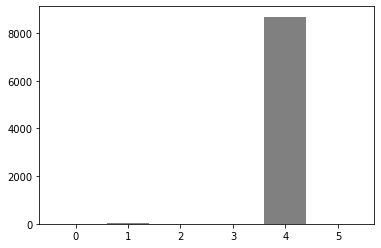

In [0]:
fig, ax = plt.subplots()
bars = ax.bar(actions_counter.keys(),
              actions_counter.values(), color='grey')
ax.set_title('Final trained model actions dist')

In [0]:
duel_dqn.load_parameters("./duel_logs/best_model.zip")

In [0]:
# Use a separate environement for evaluation
eval_env = gym.make('SpaceInvaders-ram-v0')

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(duel_dqn, eval_env, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:351.50 +/- 188.47


In [0]:
# Use a separate environement for evaluation
eval_env = gym.make('SpaceInvaders-ram-v0')

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(duel_dqn, eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:367.35 +/- 202.77


In [0]:
all_actions = actions_taken(duel_dqn)
actions_counter = Counter(all_actions)
actions_counter

In [0]:
fig, ax = plt.subplots()
bars = ax.bar(actions_counter.keys(),
              actions_counter.values(), color='grey')
ax.set_title('Best trained model actions dist')

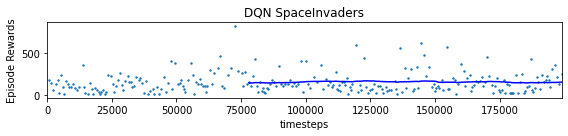

In [0]:
# Helper from the library
results_plotter.plot_results([log_dir], 2e5, results_plotter.X_TIMESTEPS,
                             "DQN SpaceInvaders")

In [0]:
record_video('SpaceInvaders-ram-v0', duel_dqn, video_length=5000,
             prefix='duel_dqn-SpaceInvaders-ram-v0')
show_videos(video_path='videos',
            prefix='duel_dqn-SpaceInvaders-ram-v0')

Saving video to  /content/videos/duel_dqn-SpaceInvaders-ram-v0-step-0-to-step-5000.mp4


This result is wierd that it because it didnt learn to move at all, but has learnt to kill very well.

This might be because of less training or less gamma value, so only maximize the short time reward and not worry about the long time reward

This result is wierd because every run I am getting the same score, 270.

The problem is it is always taking the same action.

Since the neural network is producing only one action every time, let us decrease 

In [0]:
ls

drive/                                ngrok-stable-linux-amd64.zip
duel_logs/                            ngrok-stable-linux-amd64.zip.1
duel_space_invaders_ram_tensorboard/  sample_data/
models/                               videos/
ngrok*


In [0]:
!mkdir -p drive/My\ Drive/RL_Project/Results/space_invaders_ram_v1/

In [0]:
!cp -r duel_logs drive/My\ Drive/RL_Project/Results/space_invaders_ram_v1/duel_logs

In [0]:
!cp -r duel_space_invaders_ram_tensorboard/ drive/My\ Drive/RL_Project/Results/space_invaders_ram_v1/duel_space_invaders_ram_tensorboard

In [0]:
!cp -r models/ drive/My\ Drive/RL_Project/Results/space_invaders_ram_v1/models/